### Kaggle set api-key

In [1]:
%%bash
cd /root/
ls -la
mkdir .kaggle

total 8
drwx------ 1 root root   50 Apr 28 16:43 .
drwxr-xr-x 1 root root  115 Apr 28 16:33 ..
-rw------- 1 root root    0 Mar 18 09:22 .bash_history
-rw-r--r-- 1 root root 3106 Oct 22  2015 .bashrc
drwxr-xr-x 1 root root   30 Apr 28 16:41 .cache
drwxr-xr-x 1 root root   30 Mar 18 08:17 .conda
drwxr-xr-x 2 root root   24 Mar 18 08:26 .fastai
drwxr-xr-x 5 root root   67 Apr 28 16:34 .ipython
drwxr-xr-x 3 root root   19 Apr 28 16:33 .local
-rw-r--r-- 1 root root  148 Aug 17  2015 .profile


In [3]:
%%bash
mv /notebooks/kaggle.json /root/.kaggle
chmod 600 /root/.kaggle/kaggle.json

### Download dataset

In [4]:
!pip install kaggle

In [5]:
import kaggle

kaggle.api.authenticate()
kaggle.api.dataset_download_files('kmader/skin-cancer-mnist-ham10000', 
                                  path='/notebooks/input', 
                                  unzip=False, quiet=False)

  0%|          | 0.00/5.20G [00:00<?, ?B/s]

100%|██████████| 5.20G/5.20G [02:12<00:00, 42.2MB/s]

### Unzip dataset

In [6]:
!unzip /notebooks/input/skin-cancer-mnist-ham10000.zip -d /notebooks/melanoma/

Archive:  /notebooks/input/skin-cancer-mnist-ham10000.zip
  inflating: /notebooks/melanoma/HAM10000_images_part_1/ISIC_0024306.jpg  
  inflating: /notebooks/melanoma/HAM10000_images_part_1/ISIC_0024307.jpg  
  inflating: /notebooks/melanoma/HAM10000_images_part_1/ISIC_0024308.jpg  
  inflating: /notebooks/melanoma/HAM10000_images_part_1/ISIC_0024309.jpg  
  inflating: /notebooks/melanoma/HAM10000_images_part_1/ISIC_0024310.jpg  
  inflating: /notebooks/melanoma/HAM10000_images_part_1/ISIC_0024311.jpg  
  inflating: /notebooks/melanoma/HAM10000_images_part_1/ISIC_0024312.jpg  
  inflating: /notebooks/melanoma/HAM10000_images_part_1/ISIC_0024313.jpg  
  inflating: /notebooks/melanoma/HAM10000_images_part_1/ISIC_0024314.jpg  
  inflating: /notebooks/melanoma/HAM10000_images_part_1/ISIC_0024315.jpg  
  inflating: /notebooks/melanoma/HAM10000_images_part_1/ISIC_0024316.jpg  
  inflating: /notebooks/melanoma/HAM10000_images_part_1/ISIC_0024317.jpg  
  inflating: /notebooks/melanoma/HAM10000_

In [1]:
import os
from pathlib import Path

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import numpy as np 
import pandas as pd 

from sklearn.metrics import auc,roc_curve

import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams["figure.figsize"] = 13, 7

print(os.listdir("/notebooks/melanoma"))

DATASET_PATH = Path("/notebooks/melanoma")
METADATA = DATASET_PATH / "HAM10000_metadata.csv"

['HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata.csv', 'ham10000_images_part_1', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv']


## Dataset

In [2]:
df = pd.read_csv(METADATA).set_index('image_id')

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df.dx = df.dx.astype('category',copy=True)
df['labels'] = df.dx.cat.codes 
df['lesion'] = df.dx.map(lesion_type_dict)
df.head()

,lesion_id,dx,dx_type,age,sex,localization,labels,lesion
image_id,,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,2,Benign keratosis


In [3]:
class CustomImageList(ImageList):
    def custom_label(self, df, **kwargs) -> 'LabelList':
        """Custom labels from path"""
        file_names = np.vectorize(lambda files: str(files).split('/')[-1][:-4])
        get_labels = lambda x: df.loc[x,'lesion']
        labels = get_labels(file_names(self.items))
        y = CategoryList(items=labels)
        res = self._label_list(x=self, y=y)
        return res

In [4]:
def get_data(bs, size):
    train_ds = (CustomImageList.from_folder(DATASET_PATH, extensions='.jpg')
                    .split_by_rand_pct(0.2)
                    .custom_label(df)
                    .transform(tfms=get_transforms(flip_vert=True), size=size)
                    .databunch(num_workers=2, bs=bs)
                    .normalize(imagenet_stats))
    return train_ds

In [5]:
data = get_data(16, 448)

In [6]:
data.classes = list(np.unique(df.lesion))  
data.c = len(np.unique(df.lesion))  

In [7]:
data

ImageDataBunch;

Train: LabelList (16024 items)
x: CustomImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
Melanocytic nevi,Melanocytic nevi,Melanocytic nevi,Melanoma,Melanocytic nevi
Path: /notebooks/melanoma;

Valid: LabelList (4006 items)
x: CustomImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
Melanocytic nevi,Melanocytic nevi,Benign keratosis ,Melanocytic nevi,Melanocytic nevi
Path: /notebooks/melanoma;

Test: None

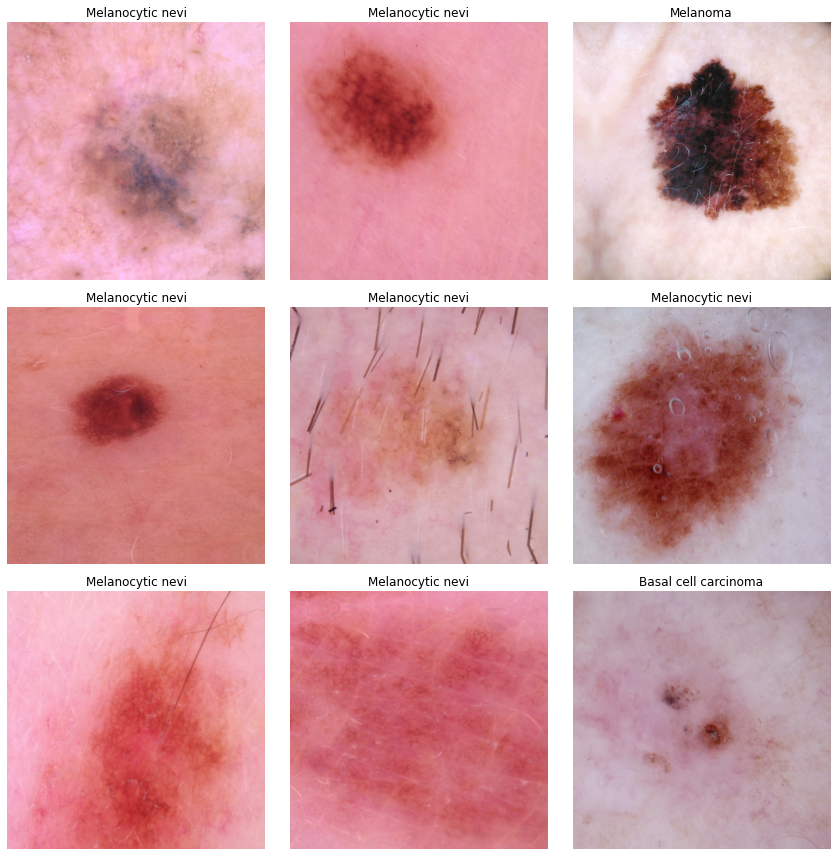

In [8]:
data.show_batch(rows=3)

## ResNet34

In [9]:
learner = cnn_learner(
    data, 
    models.resnet34, 
    metrics=[accuracy], 
    model_dir="/notebooks/model", 
    pretrained=True
)

In [10]:
learner.loss_func = nn.CrossEntropyLoss()

### Train only last layer

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02
Min loss divided by 10: 1.74E-02


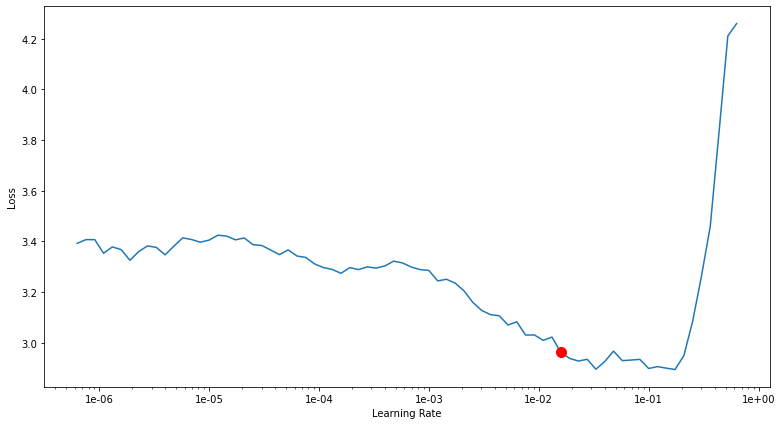

In [15]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [17]:
learner.fit_one_cycle(10, 1.55e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.839497,0.716720,0.760609,07:45
1,0.799162,0.870295,0.708437,07:26
2,0.765595,2.105536,0.715926,07:15
3,0.803223,0.761608,0.769596,07:13
4,0.705687,1.010570,0.744883,07:12
5,0.649485,0.698219,0.788817,07:08
6,0.578063,0.693932,0.816276,07:10
7,0.583475,1.184007,0.829506,07:09
8,0.511719,0.607558,0.847229,06:54
9,0.455803,0.867980,0.845981,06:55


In [17]:
# learner.recorder.plot_losses()

### Full network retrain

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03
Min loss divided by 10: 1.45E-02


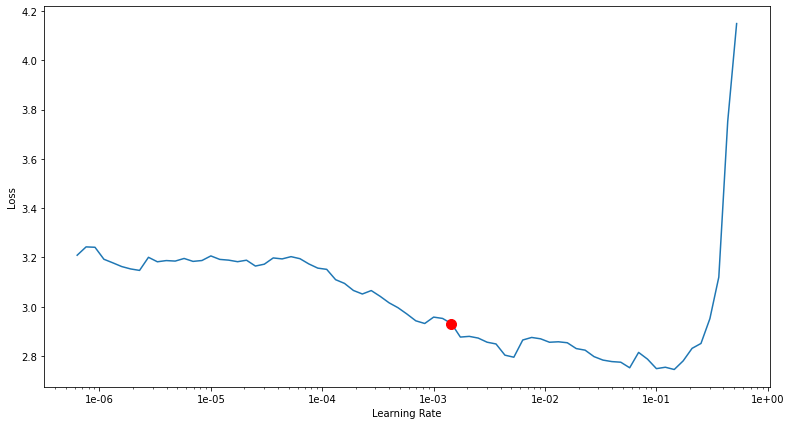

In [18]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [ ]:
learner.fit_one_cycle(30, max_lr=slice(1.45e-03, 1.8e-03))

epoch,train_loss,valid_loss,accuracy,time
0,1.189572,0.821035,0.782327,07:38
1,1.003818,0.711065,0.758113,07:39
2,0.837592,0.653862,0.754119,07:40
3,0.921708,0.696526,0.742137,07:44
4,0.925229,0.821467,0.677234,07:44
5,0.916184,0.923941,0.701448,07:42
6,0.803922,0.639308,0.766850,07:43
7,0.775633,0.638167,0.758862,07:53
8,0.773074,0.621201,0.767848,08:12
9,0.772932,0.653965,0.758362,08:15


In [ ]:
learner.save('full')

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused()

## Inference

In [ ]:
pred_data = get_data(16,224)

In [ ]:
pred_data.classes = list(np.unique(df.lesion))  
pred_data.c = len(np.unique(df.lesion)) 

In [ ]:
pred_data.single_from_classes(DATASET_PATH, pred_data.classes)

In [ ]:
predictor = cnn_learner(pred_data, models.resnet50, model_dir="/notebooks/model").load('full')

In [ ]:
img = open_image(DATASET_PATH / 'ham10000_images_part_2/ISIC_0029886.jpg')
img

In [ ]:
pred_class, pred_idx, outputs = predictor.predict(img)
pred_class

## Predictions

In [ ]:
preds_val, y_val = learner.get_preds()

### ROC AUC

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val.numpy(), preds_val.numpy()[:,1], pos_label=1)

pred_score = auc(fpr, tpr)
print(f'ROC area is {pred_score}')

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % pred_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## Heatmap

In [ ]:
x, y = data.valid_ds[2]
x.show()
data.valid_ds.y[2]

In [ ]:
def plot_heat_map(x, y, data, learner, size=(0,224,224,0)):
    m = learner.model.eval()
    
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(y)].backward()

    acts = hook_a.stored[0].cpu()
    
    avg_acts = acts.mean(0)
    
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(avg_acts, alpha=0.6, extent=size,
              interpolation='bilinear', cmap='magma')

In [ ]:
plot_heat_map(x, y, pred_data, learner)